In [ ]:
# # This file is part of Theano Geometry
#
# Copyright (C) 2017, Stefan Sommer (sommer@di.ku.dk)
# https://bitbucket.org/stefansommer/theanogemetry
#
# Theano Geometry is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Theano Geometry is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Theano Geometry. If not, see <http://www.gnu.org/licenses/>.
#

# Latent Space Geometry
arXiv:1805.07632 [cs.CV] https://arxiv.org/abs/1805.07632

Line Kuhnel, Tom Fletcher, Sarang Joshi, and Stefan Sommer

In [1]:
%cd ..
# check Keras / Theano Geometry compatibility
from keras import backend as K
import theano
print(theano.config.floatX)
print(K.floatx())
assert(theano.config.floatX == K.floatx())

/home/line/Dropbox/theanogeometry


Using Theano backend.


float32
float32


In [2]:
import matplotlib.pyplot as plt
plt.show()

In [3]:
# S2 or MNIST example
#name = 'mnist'
name = 'S2'

In [4]:
if name is 'S2':
    import numpy as np
    from mpl_toolkits.mplot3d import axes3d
    
    def sample_spherical(npoints, ndim=3):
        vec = np.random.randn(ndim, npoints)
        vec /= np.linalg.norm(vec, axis=0)
        return (vec[0],vec[1],abs(vec[2]))
    
    phi = np.linspace(0, np.pi, 20)
    theta = np.linspace(0, 2 * np.pi, 40)
    x = np.outer(np.sin(theta), np.cos(phi))
    y = np.outer(np.sin(theta), np.sin(phi))
    z = np.outer(np.cos(theta), np.ones_like(phi))
    
    xi, yi, zi = sample_spherical(1000)
    
    #np.save('S2_samples.npy',np.array([xi,yi,zi]).T)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          512         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            258         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            258         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

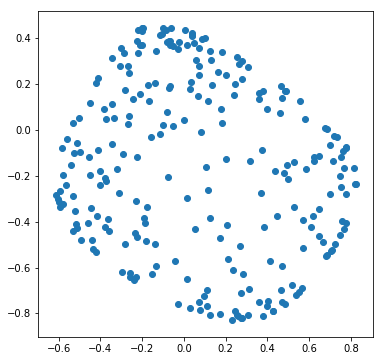

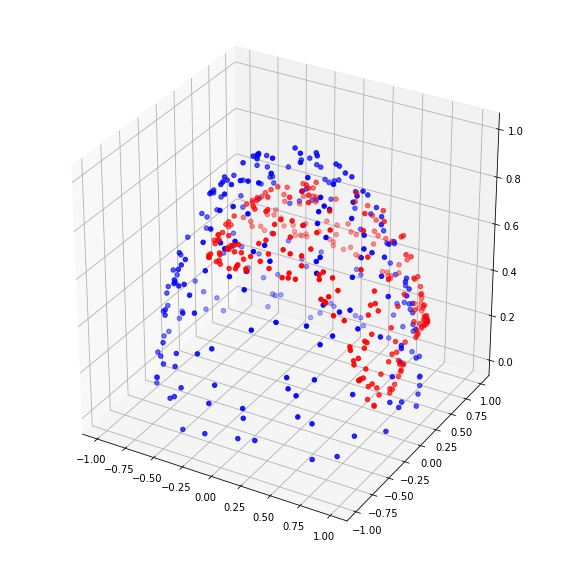

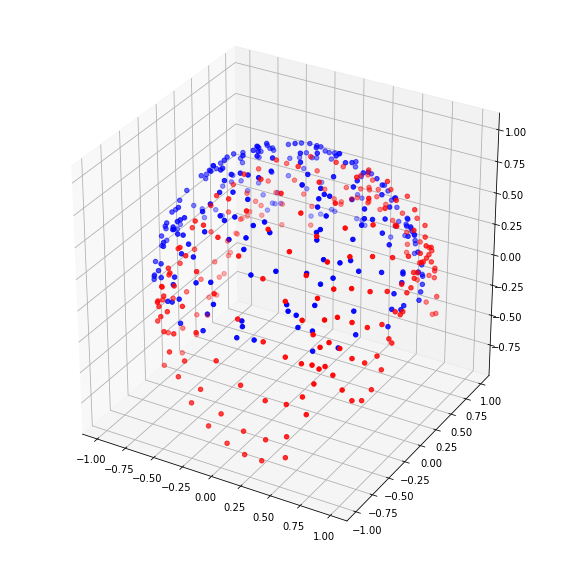

In [5]:
if name is 'S2':
    ## setup neural network

    # adapted from Keras variational_autoencoder.py example 
    # https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py
    '''This script demonstrates how to build a variational autoencoder with Keras.
     #Reference
     - Auto-Encoding Variational Bayes
       https://arxiv.org/abs/1312.6114
    '''

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import norm

    from keras.layers import Input, Dense, Lambda
    from keras.models import Model
    from keras import backend as K
    from keras import metrics
    from keras import optimizers

    batch_size = 100
    original_dim = 3
    latent_dim = 2
    intermediate_dim = 128
    epochs = 1000
    epsilon_std = .1

    x = Input(shape=(original_dim,))
    encoder_h = Dense(intermediate_dim, activation='tanh')
    h = encoder_h(x)
    encoder_z_mean = Dense(latent_dim)
    z_mean = encoder_z_mean(h)
    z_log_var = Dense(latent_dim)(h)


    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # we instantiate these layers separately so as to reuse them later
    decoder_h = Dense(intermediate_dim, activation='tanh')
    decoder_mean = Dense(original_dim, activation='tanh')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # instantiate VAE model
    vae = Model(x, x_decoded_mean)

    # Compute VAE loss
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer=optimizers.RMSprop(lr=0.01,))
    vae.summary()

    # train the VAE on S2 samples
    x_train = np.load('S2_samples.npy')
    x_test = x_train[3*x_train.shape[0]//4:-1,:]
    x_train = x_train[0:3*x_train.shape[0]//4,:]

    vae.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None),
            verbose=0)

    # build a model to project inputs on the latent space
    encoder = Model(x, z_mean)

    # display a 2D plot of the data in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1])
    plt.show()

    # build a digit generator that can sample from the learned distribution
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = decoder_h(decoder_input)
    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)

    # decode test data
    x_test_decoded = generator.predict(x_test_encoded, batch_size=batch_size)
    plt.figure(figsize=(10, 10))
    from mpl_toolkits.mplot3d import Axes3D
    ax = plt.gca(projection='3d')
    ax.scatter(x_test_decoded[:,0],x_test_decoded[:,1],x_test_decoded[:,2],color='red')
    ax.scatter(x_test[:,0],x_test[:,1],x_test[:,2],color='blue')
    ax.set_aspect("equal")
#     plt.savefig('S2_test.pdf')
    plt.show()

    # display the image of the latent space in the embedding space
    n = 15
    points = np.zeros((n,n,3))
    # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
    # to produce values of the latent variables z, since the prior of the latent space is Gaussian
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = generator.predict(z_sample)
            points[i,j] = x_decoded[0]
    points = points.reshape((-1,3))
    plt.figure(figsize=(10, 10))
    from mpl_toolkits.mplot3d import Axes3D
    ax = plt.gca(projection='3d')
    ax.scatter(points[:,0],points[:,1],points[:,2],color='red')
    ax.scatter(x_test[:,0],x_test[:,1],x_test[:,2],color='blue')
    ax.set_aspect("equal")
    plt.show()

In [ ]:
if name is 'mnist':
    ## setup neural network

    # adapted from Keras variational_autoencoder.py example 
    # https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py
    '''This script demonstrates how to build a variational autoencoder with Keras.
     #Reference
     - Auto-Encoding Variational Bayes
       https://arxiv.org/abs/1312.6114
    '''

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import norm

    from keras.layers import Input, Dense, Lambda
    from keras.models import Model
    from keras import backend as K
    from keras import metrics
    from keras.datasets import mnist

    batch_size = 100
    original_dim = 784
    latent_dim = 2
    intermediate_dim = 256
    epochs = 50
    epsilon_std = 1.0

    x = Input(shape=(original_dim,))
    encoder_h = Dense(intermediate_dim, activation='tanh')
    h = encoder_h(x)
    encoder_z_mean = Dense(latent_dim)
    z_mean = encoder_z_mean(h)
    z_log_var = Dense(latent_dim)(h)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # we instantiate these layers separately so as to reuse them later
    decoder_h = Dense(intermediate_dim, activation='tanh')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # instantiate VAE model
    vae = Model(x, x_decoded_mean)

    # Compute VAE loss
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    vae.summary()

    # train the VAE on MNIST digits
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

    vae.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))

    # build a model to project inputs on the latent space
    encoder = Model(x, z_mean)

    # display a 2D plot of the digit classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
    plt.colorbar()
    plt.show()

    # build a digit generator that can sample from the learned distribution
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = decoder_h(decoder_input)
    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)

    # display a 2D manifold of the digits
    n = 15  # figure with 15x15 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
    # to produce values of the latent variables z, since the prior of the latent space is Gaussian
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = generator.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

In [6]:
# build a generator for Theano Geometry
def F(x):
    decoder_input = Input(shape=(latent_dim,),tensor=x.reshape((1,-1)))
    _h_decoded = decoder_h(decoder_input)
    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)
    return generator.layers[-1].get_output_at(-1).flatten()

# build inverse mapping
def invF(y):
    x = Input(shape=(original_dim,),tensor=y.reshape((1,-1)))
    h = encoder_h(x)
    z_mean = encoder_z_mean(h)
    encoder = Model(x, z_mean)
    return encoder.layers[-1].get_output_at(-1).flatten()

In [9]:
from src.manifolds.latent import *
M = Latent(F,latent_dim,original_dim,invF=invF)
print(M)

from src.plotting import *
#if name is 'S2':
#    M.newfig()
#    M.plot()#alpha=.5)
#     plt.savefig(name+'_learned_manifold.pdf')
#    plt.show()

dim 2 manifold embedded in R^3


In [10]:
# learn metric structure

# Riemannian structure
from src.Riemannian import metric
metric.initialize(M)
# save metric
if not hasattr(M,'g_org'):
    M.g_org = M.g
    M.g_orgf = M.gf    
    M.gsharp_org = M.gsharp
    M.gsharp_orgf = M.gsharpf

# triangular matrix functions
r = T.arange(M.dim)
tmp_mat = r[np.newaxis, :] + ((M.dim * (M.dim - 3)) // 2-(r * (r - 1)) // 2)[::-1,np.newaxis]
triu_index_matrix = T.triu(tmp_mat+1)-T.diag(T.diagonal(tmp_mat+1))

def VtoLA(hatxi): # from \RR^G_dim to LA
    if hatxi.type == T.vector().type:
        m = T.concatenate((T.zeros(1),hatxi[M.dim:]))[triu_index_matrix]
        return m+m.T+T.diag(hatxi[:M.dim])
    else: # matrix
        N = hatxi.shape[0]
        m = T.concatenate((T.zeros((1,hatxi.shape[0])),hatxi[:,M.dim:].T))[triu_index_matrix,:]
        return (m+m.dimshuffle((1,0,2))).dimshuffle((2,0,1))+T.tile(hatxi[:,:M.dim].reshape((N,M.dim,1)),(1,1,int(M.dim.eval())))*T.tile(T.eye(M.dim).reshape((1,M.dim,M.dim)),(N,1,1))    
LAtoV = lambda m: T.concatenate((T.diag(m),m[T.triu(T.ones((int(M.dim.eval()),int(M.dim.eval())))-T.diag(T.ones(M.dim))).nonzero()])) # from LA to \RR^G_dim

hatxi = T.vector()
VtoLAf = theano.function([hatxi],VtoLA(hatxi))
# # VtoLAf(np.array([[1.,2.,3.],[-1.,-2.,-3.]]))
mm = T.matrix()
LAtoVf = theano.function([mm],LAtoV(mm))
# print(VtoLAf(np.array([1.,2.,3.])))
# LAtoVf(VtoLAf(np.array([1.,2.,3.])))

# samples, n sample points per axis
n = 301
samples = np.zeros((n,n,M.dim.eval()))
g_samples = np.zeros((n,n,2,M.dim.eval()*(M.dim.eval()+1)//2))

# grid
from scipy.stats import norm
xmin = np.min(x_test_encoded[:,0])
xmax = np.max(x_test_encoded[:,0])
ymin = np.min(x_test_encoded[:,1])
ymax = np.max(x_test_encoded[:,1])
if name is 'S2':
    grid_x = norm.ppf(np.linspace(0.005, 0.995, n))
    grid_y = norm.ppf(np.linspace(0.005, 0.995, n))    
if name is 'mnist':
    grid_x = 1.1*np.linspace(xmin,xmax,n)
    grid_y = 1.1*np.linspace(ymin,ymax,n)
print(n)
xmin = np.min(grid_x)
xmax = np.max(grid_x)
ymin = np.min(grid_y)
ymax = np.max(grid_y)
print(xmin,xmax,ymin,ymax)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        samples[i,j] = np.array([[xi, yi]])
        g = M.g_orgf(samples[i,j].astype(theano.config.floatX))
        g_samples[i,j][0] = LAtoVf(M.g_orgf(samples[i,j].astype(theano.config.floatX)))
        g_samples[i,j][1] = LAtoVf(M.gsharp_orgf(samples[i,j].astype(theano.config.floatX)))
samples = samples.reshape((n**2, np.prod(samples.shape[2:])))
g_samples = g_samples.reshape((n**2, np.prod(g_samples.shape[2:])))

g_input = Input(shape=(latent_dim,))
if name is 'S2':
    layer_h_g = Dense(512, activation='tanh')
if name is 'mnist':
    layer_h_g = Dense(2048, activation='tanh')
h_g = layer_h_g(g_input)
layer_h_g2 = Dense(8, activation='tanh')
h_g2 = layer_h_g2(h_g)
layer_g_predicted = Dense(2*M.dim.eval()*(M.dim.eval()+1)//2, activation='linear')
g_predicted = layer_g_predicted(h_g2)
g_predictor = Model(g_input,g_predicted)

# g and gsharp differencce
def loss_diff(yTrue,yPred):
    yTrue = yTrue.reshape((-1,2,M.dim*(M.dim+1)//2))
    yPred = yPred.reshape((-1,2,M.dim*(M.dim+1)//2))
    N = yTrue.shape[0]
    gTrue = VtoLA(yTrue[:,0])
    gsharpTrue = VtoLA(yTrue[:,1])    
    gPred = VtoLA(yPred[:,0])
    gsharpPred = VtoLA(yPred[:,1])
    return ( K.mean((T.sum(K.square(gPred-gTrue),(1,2))/T.sum(abs(gTrue**2),(1,2))).flatten())
            +K.mean((T.sum(K.square(gsharpPred-gsharpTrue),(1,2))/T.sum(abs(gsharpTrue**2),(1,2))).flatten()))
# g and gsharp differencce and measure of g,gsharp being inverses
def loss_inverse(yTrue,yPred):
    yTrue = yTrue.reshape((-1,2,M.dim*(M.dim+1)//2))
    yPred = yPred.reshape((-1,2,M.dim*(M.dim+1)//2))
    N = yTrue.shape[0]
    gPred = VtoLA(yPred[:,0])
    gsharpPred = VtoLA(yPred[:,1])
    return K.mean(K.square(K.batch_dot(gsharpPred,gPred,(2,1))-K.tile(K.eye(M.dim.eval()).reshape((1,M.dim,M.dim)),(N,1,1))).flatten())
loss_init = loss_diff
loss = lambda yTrue,yPred: loss_diff(yTrue,yPred)+loss_inverse(yTrue,yPred)

g_predictor_init = Model(g_input,g_predicted)
g_predictor_init.compile(loss=loss_init,optimizer='rmsprop',metrics=[loss_inverse]) # run some iterations of this to initialize weights before using custom loss
g_predictor.compile(loss=loss,optimizer='rmsprop',metrics=[loss_diff,loss_inverse])
g_predictor.summary()

# train
g_predictor_init.fit(samples,g_samples,
        shuffle=True,
        epochs=2000,
        batch_size=n**2//100,
        verbose=0
#         validation_data=(x_test, None)
               )
print("training result init: %s" % g_predictor_init.evaluate(samples,g_samples))
x = np.array([0.,0.]).astype(theano.config.floatX)
print(M.g_orgf(x))
print(M.gsharp_orgf(x))
print(g_predictor.predict(np.array([0.,0.]).astype(theano.config.floatX).reshape((1,-1))))
g_predictor.fit(samples,g_samples,
        shuffle=True,
        epochs=2000,
        batch_size=n**2//100,
        verbose=0
#         validation_data=(x_test, None)
               )
print("training result: %s" % g_predictor.evaluate(samples,g_samples))
print(M.g_orgf(x))
print(np.linalg.norm(M.g_orgf(x),-2))
print(M.gsharp_orgf(x))
print(np.linalg.norm(M.gsharp_orgf(x),-2))
print(g_predictor.predict(np.array([0.,0.]).astype(theano.config.floatX).reshape((1,-1))))

301
-2.575829303548901 2.5758293035489004 -2.575829303548901 2.5758293035489004
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 4104      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 54        
Total params: 5,694
Trainable params: 5,694
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: 

In [ ]:
# create new metric and cometric and add to M

inside = lambda x: T.and_(T.and_(T.ge(x[0],xmin),T.le(x[0],xmax)),T.and_(T.ge(x[1],ymin),T.le(x[1],ymax)))

def g(x):
    g_input = Input(shape=(latent_dim,),tensor=x.reshape((1,-1)))
    h_g = layer_h_g(g_input)
    h_g2 = layer_h_g2(h_g)
    g_predicted = layer_g_predicted(h_g2)
    g_predictor = Model(g_input,g_predicted)

#     return theano.ifelse.ifelse(1,VtoLA(g_predictor.layers[-1].get_output_at(-1).reshape((2,-1))[0]),M.g_org(x))
    return VtoLA(g_predictor.layers[-1].get_output_at(-1).reshape((2,-1))[0])
def gsharp(x):
    g_input = Input(shape=(latent_dim,),tensor=x.reshape((1,-1)))
    h_g = layer_h_g(g_input)
    h_g2 = layer_h_g2(h_g)
    g_predicted = layer_g_predicted(h_g2)    
    g_predictor = Model(g_input,g_predicted)

#     return theano.ifelse.ifelse(inside(x),VtoLA(g_predictor.layers[-1].get_output_at(-1).reshape((2,-1))[1]),M.gsharp_org(x))
    return VtoLA(g_predictor.layers[-1].get_output_at(-1).reshape((2,-1))[1])

zz = T.vector()
gf = theano.function([zz],g(zz))
gsharpf = theano.function([zz],gsharp(zz))
M.g = g
M.gf = gf
M.gsharp = gsharp
M.gsharpf = gsharpf

# re-initialize Riemannian structure
metric.initialize(M)

# some values
x = np.array([0.,0.]).astype(theano.config.floatX)
print(M.g_orgf(x))
print(M.gf(x))
print(M.g_orgf(x)-M.gf(x))
print(np.linalg.eigvals(M.g_orgf(x)))
print(np.linalg.eigvals(M.gf(x)))
print()
print(M.gsharp_orgf(x))
print(M.gsharpf(x))
print(M.gsharp_orgf(x)-M.gsharpf(x))
print(np.linalg.eigvals(M.gsharp_orgf(x)))
print(np.linalg.eigvals(M.gsharpf(x)))
print()
print(np.dot(M.gsharpf(x),M.gf(x)))
print(np.dot(M.gf(x),M.gsharpf(x)))

## Riemannian Geodesics

In [ ]:
# element, tangent vector and covector
x = np.array([0.,0.]).astype(theano.config.floatX)
v = np.array([1.,1.]).astype(theano.config.floatX)
p = M.flatf(x,v)

print("x = ", x)
print("v = ", v)
print("p = ", p)

In [ ]:
# 2nd order geodesic equation
from src.Riemannian import geodesic
geodesic.initialize(M)

# compute geodesics
xs = M.Exptf(x,v)

# plot
M.newfig()
M.plot()
M.plotx(xs,v,linewidth = 1.5, s=50)
# plt.savefig(name+'_geodesic.pdf')
plt.show()

### Geodesics from Hamiltonian equations

In [ ]:
# Hamiltonian dynamics
q = x
print(M.Hf(q,p))

from src.dynamics import Hamiltonian
Hamiltonian.initialize(M)

# Exponential map from Hamiltonian equations
qs = M.Exp_Hamiltoniantf(q,p).T

# plot
M.newfig()
M.plot()
M.plotx(qs,v)
plt.show()

# dynamics returning both position and momentum
(ts,qps) = M.Hamiltonian_dynamicsf(q,p)
ps = qps[:,1,:]
print("Energy: ",np.array([M.Hf(q,p) for (q,p) in zip(qs,ps)]))

In [ ]:
# time results of different geodesic schemes

# %time xs = M.Exp_embeddedtf(x,v)
%time xs = M.Exp_Hamiltoniantf(x,v)
%time xs = M.Exptf(x,v)

## Curvature

In [ ]:
from src.Riemannian import curvature
curvature.initialize(M)
# Curvature tensor, Ricci and scalar curvature:
print("curvature = ", M.Rf(x))
print("Ricci curvature = ", M.Ricci_curvf(x))
print("Scalar curvature = ", M.S_curvf(x))

# Orthonormal basis under g:
nu = M.gramSchmidt(x,np.eye(2).astype(theano.config.floatX)) # or nu = np.linalg.cholesky(M.gsharpf(x))

# Sectional Curvature
print("sectional curvature = ",M.sec_curvf(x,nu[:,0],nu[:,1]))

In [ ]:
# plot min of Ricci curvature tensor

# grids
pts = 200 # high value implies nicer plot but extended computation time
if name is 'S2':
    border = 1.
if name is 'mnist':
    border = 2.
minx = -border
maxx = +border
miny = -border
maxy = +border
X, Y = np.meshgrid(np.linspace(minx,maxx,pts),np.linspace(miny,maxy,pts))
xy = np.vstack([X.ravel(), Y.ravel()]).T        

if name is 'S2':
    vmin = -2.
    vmax = 2.   
if name is 'mnist':
    vmin = -.6
    vmax = .6
    
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)

# plot
newfig()
cmap = cm.jet
alpha = 1
ax = plt.gca()
fs = np.array([M.S_curvf(x.astype(theano.config.floatX)) for x in xy])
# norm = mpl.colors.Normalize(vmin=np.min(fs),vmax=np.max(fs))
colors = cmap(norm(fs)).reshape(X.shape+(4,))
surf = ax.plot_surface(X, Y, fs.reshape(X.shape), rstride=1, cstride=1, cmap=cmap, facecolors = colors,  linewidth=0., antialiased=True, alpha=alpha, edgecolor=(0,0,0,0), shade=False)
m = cm.ScalarMappable(cmap=surf.cmap,norm=norm)
m.set_array(colors)
# plt.colorbar(m, shrink=0.7)
ax.set_xlim3d(minx,maxx), ax.set_ylim3d(miny,maxy), ax.set_zlim3d(vmin,vmax)#np.min(fs)-1,np.max(fs)+1)
# plt.savefig(name+'_scalar_curvature.pdf')
plt.show()

# plot
newfig()
cmap = cm.jet
alpha = 1
ax = plt.gca()
fs = np.array([np.min(np.real(np.linalg.eigvals(np.dot(M.gsharpf(x.astype(theano.config.floatX)),M.Ricci_curvf(x.astype(theano.config.floatX)))))) for x in xy])
# norm = mpl.colors.Normalize(vmin=np.min(fs),vmax=np.max(fs))
colors = cmap(norm(fs)).reshape(X.shape+(4,))
surf = ax.plot_surface(X, Y, fs.reshape(X.shape), rstride=1, cstride=1, cmap=cmap, facecolors = colors,  linewidth=0., antialiased=True, alpha=alpha, edgecolor=(0,0,0,0), shade=False)
m = cm.ScalarMappable(cmap=surf.cmap,norm=norm)
m.set_array(colors)
# plt.colorbar(m, shrink=0.7)
ax.set_xlim3d(minx,maxx), ax.set_ylim3d(miny,maxy), ax.set_zlim3d(vmin,vmax)#(np.min(fs)-1,np.max(fs)+1)
# plt.savefig(name+'_min_Ricci.pdf')
plt.show()

# plot
newfig()
cmap = cm.jet
alpha = 1
ax = plt.gca()
fs = np.array([np.max(np.real(np.linalg.eigvals(np.dot(M.gsharpf(x.astype(theano.config.floatX)),M.Ricci_curvf(x.astype(theano.config.floatX)))))) for x in xy])
# norm = mpl.colors.Normalize(vmin=np.min(fs),vmax=np.max(fs))
colors = cmap(norm(fs)).reshape(X.shape+(4,))
surf = ax.plot_surface(X, Y, fs.reshape(X.shape), rstride=1, cstride=1, cmap=cmap, facecolors = colors,  linewidth=0., antialiased=True, alpha=alpha, edgecolor=(0,0,0,0), shade=False)
m = cm.ScalarMappable(cmap=surf.cmap,norm=norm)
m.set_array(colors)
# plt.colorbar(m, shrink=0.7)
ax.set_xlim3d(minx,maxx), ax.set_ylim3d(miny,maxy), ax.set_zlim3d(vmin,vmax)#(np.min(fs)-1,np.max(fs)+1)
# plt.savefig(name+'_max_Ricci.pdf')
plt.show()

plt.figure()
plt.colorbar(m)
# plt.savefig(name+'_curvature_colorbar.pdf')
plt.show()

## Parallel Transport

In [ ]:
# Parallel transport
from src.Riemannian import parallel_transport
parallel_transport.initialize(M)

v = np.array([-1./2,-1./2]).astype(theano.config.floatX)
v = v/M.normf(x,v)
t = np.linspace(0,1,n_steps.get_value())
gamma = 2*np.vstack([-t**2,-np.sin(t)]).T.astype(theano.config.floatX)
dgamma = 2*np.vstack([-2*t,-np.cos(t)]).T.astype(theano.config.floatX)

# compute  parallel transport
vt = M.parallel_transportf(v,gamma,dgamma)

# plot result
M.newfig()
M.plot()
M.plotx(gamma,v=vt,N_vec=np.arange(0,n_steps.eval(),2))
if name is 'mnist':
    plt.xlim([-2.2,.1])
# plt.savefig(name+'_parallel_transport.pdf')
plt.show()

## Brownian Motion

In [ ]:
# # coordinate form
from src.stochastics import Brownian_coords
Brownian_coords.initialize(M)

tsteps = n_steps.eval(); n_steps.set_value(1000)
N = 5
xss = np.zeros((N,n_steps.eval(),M.dim.eval()))
for i in range(N):
    (ts,xs) = M.Brownian_coordsf(x,dWsf(M.dim.eval()))
    xss[i] = xs
n_steps.set_value(tsteps)

# plot
M.newfig()
M.plot()
colormap = plt.get_cmap('winter')
colors=[colormap(k) for k in np.linspace(0, 1, N)]
for i in range(N):
    M.plotx(xss[i],color=colors[i])
M.plotx(x,color='r',s=150)
# plt.savefig(name+'_Brownian.pdf')
plt.show()

In [ ]:
# time results of Brownian motion integrations

%time xs = M.Brownian_coordsf(x,dWsf(M.dim.eval()))
# %time xs = M.Brownian_embeddedf(x,dWsf(M.dim.eval()))

In [ ]:
# Delyon/Hu guided process
from src.stochastics.guided_process import *

# guide function
Cholesky = T.slinalg.Cholesky()
# phi = lambda q,v: T.tensordot(T.nlinalg.MatrixInverse()(Cholesky(M.gsharp(q))),-(q-v).flatten(),(1,0))
phi = lambda q,v: T.tensordot(Cholesky(M.g(q)).T,-(q-v).flatten(),(1,0))
x0 = M.element()
(Brownian_coords_guided,Brownian_coords_guidedf) = get_guided_likelihood(M,M.sde_Brownian_coords,phi,lambda x: Cholesky(M.gsharp(x)),x0)

if name is 'S2':
    x0 = x
    x1 = M.Exptf(x,np.array([.8,-.5]).astype(theano.config.floatX))[-1]
if name is 'mnist':
    x0 = np.random.permutation(x_test_encoded[y_test == 9,:])[0] # pick a number 9
    x1 = np.random.permutation(x_test_encoded[y_test == 4,:])[0] # pick a number 4

tsteps = n_steps.eval(); n_steps.set_value(1000)
N = 5
xss = np.zeros((N,n_steps.eval(),M.dim.eval()))
for i in range(N):
    if name is 'S2':
        noise = .2*dWsf(M.dim.eval())
    if name is 'mnist':
        noise = dWsf(M.dim.eval())
    (ts,xs,log_likelihood,log_varphi) = Brownian_coords_guidedf(x0,x1,noise)[:4]
    xss[i] = xs
    print("log likelihood: ", log_likelihood[-1], ", log varphi: ", log_varphi[-1])

# plot
M.newfig()
M.plot()
colormap = plt.get_cmap('winter')
colors=[colormap(k) for k in np.linspace(0, 1, N)]
for i in range(N):
    M.plotx(xss[i],color=colors[i])
M.plotx(x0,color='r',s=150)
M.plotx(x1,color='k',s=150)
# plt.savefig(name+'_bridges.pdf')
plt.show()

if name is 'mnist':
    def plot_images(xs,n_t):
        indices = np.ceil(np.linspace(0,xs.shape[0]-1,n_t)).astype('int')

        # plot
        image = np.zeros((28,28*len(indices)))
        for j,i in enumerate(indices):
            image[:,j*28:(j+1)*28] = M.Ff(xs[i,:]).reshape((28,28))
        plt.figure(figsize=(15, 3))
        plt.imshow(image, cmap='Greys_r')
        plt.axis('off')

    for i in range(N):
        (ts,xs,log_likelihood,log_varphi) = Brownian_coords_guidedf(x0,x1,2*dWsf(M.dim.eval()))[:4]
        plot_images(xs,11)    
#         plt.savefig(name+'_image_bridges'+str(i)+'.pdf')
        plt.show()

n_steps.set_value(tsteps)

## PCA

In [ ]:
# samples
if name is 'S2':
    samples = x_test_encoded[np.random.permutation(x_test_encoded.shape[0])]
if name is 'mnist':
    odds = np.random.permutation(np.where(y_test % 2 == 0)[0])
    samples = x_test_encoded[odds] # select odd numbers
    samples_y = y_test[odds]

In [ ]:
# Logarithm map
from src.Riemannian import Log
Log.initialize(M,M.Exp)

In [ ]:
from src.statistics.Frechet_mean import *

%time res = Frechet_mean(M,lambda *args: M.Logf(*args),samples[:256],options={'disp': True} )
Fm = res[0]
print("loss = ", res[1])
print("mean = ", Fm)
iterations = res[2]

# plot
M.newfig()
if name is 'S2':
    M.plot()
    for i in range(256):
        M.plotx(samples[i])
if name is 'mnist':
    plt.scatter(samples[:256, 0], samples[:256, 1], marker='.', s=70, cmap=plt.get_cmap('hsv'))
M.plotx(Fm,s=150)
M.plotx(iterations,color='green',linewidth=2.5)
# plt.savefig(name+'_FM_iterations.pdf')
plt.show()

if name is 'mnist':
    # plot image
    plt.imshow(M.Ff(Fm).reshape((28,28)), cmap='Greys_r')
#     plt.savefig(name+'_FM.pdf')
    plt.show()

In [ ]:
from src.statistics.tangent_PCA import *

pca = tangent_PCA(M,lambda *args: M.Logf(*args),Fm,samples)

In [ ]:
# display a 2D plot of the digit classes in the PCA coordinates
plt.figure(figsize=(18, 12))
if name is 'S2':
    plt.scatter(pca.transformed_Logs[:, 0], pca.transformed_Logs[:, 1])    
if name is 'mnist':
    plt.scatter(pca.transformed_Logs[:, 0], pca.transformed_Logs[:, 1], c=samples_y[:pca.transformed_Logs.shape[0]],cmap=plt.get_cmap('hsv'))    
#     plt.xlim([-.6,.6]);plt.ylim([-.45,.45]);
#     plt.colorbar()
# plt.savefig(name+'_pga.pdf')
plt.show()

if name is 'mnist':
    # display a 2D plot of the digit classes in the latent space
    plt.figure(figsize=(18, 12))
    plt.scatter(samples[:, 0], samples[:, 1], c=samples_y, cmap=plt.get_cmap('hsv'))
#     plt.colorbar()
#     plt.savefig(name+'_latent.pdf')
    plt.show()
    
    # visualize geodesics along major principal component
    v0 = pca.components_[:,0]
    print(v0)
    print(np.sqrt(pca.explained_variance_))

    sigma = 10*np.sqrt(pca.explained_variance_[0])
    xs = M.Exptf(Fm,-sigma*v0)
    xs = np.concatenate((xs[::-1],M.Exptf(Fm,sigma*v0)))

    plot_images(xs,11)
#     plt.savefig(name+'_first_pcomp.pdf')
    plt.show()
    
    # visualize geodesics along minor principal component
    v1 = pca.components_[:,1]
    print(v1)

    sigma = 10*np.sqrt(pca.explained_variance_[1])
    xs = M.Exptf(Fm,-sigma*v1)
    xs = np.concatenate((xs[::-1],M.Exptf(Fm,sigma*v1)))

    plot_images(xs,11)
#     plt.savefig(name+'_second_pcomp.pdf')
    plt.show()

# Hotelling two sample test

# ML mean estimation

In [ ]:
options = {}
if name is 'S2':
    options['samples_per_obs'] = 1
    options['epochs'] = 200
    options['learning_rate'] = .5e-1#1.5e-3
    options['varphi_update_rate'] = 1.
    options['initial'] = [np.zeros(M.dim.eval()),]
    options['verbose'] = True
if name is 'mnist':
    options['samples_per_obs'] = 1
    options['epochs'] = 200
    options['learning_rate'] = 1.e-1#1.5e-3
    options['varphi_update_rate'] = 1.
    options['initial'] = [np.zeros(M.dim.eval()),]
    options['verbose'] = True

In [ ]:
# Transition density
# transition density etc.
q0 = M.element()
v = M.element()
thetas = (q0,)
log_p_Tf = theano.function([q0,v],log_p_T(q0,v,dWs(M.dim),Brownian_coords_guided,phi,options,sde=M.sde_Brownian_coords))
dlog_p_Tf = theano.function([q0,v],dlog_p_T(thetas,q0,v,dWs(M.dim),Brownian_coords_guided,phi,options,sde=M.sde_Brownian_coords))
p_Tf = theano.function([q0,v],T.exp(log_p_T(q0,v,dWs(M.dim),Brownian_coords_guided,phi,options,sde=M.sde_Brownian_coords)))

v = M.Exp_Hamiltonianf(q,p)
%time print(log_p_Tf(q,v))
%time print(p_Tf(q,v))
%time print(dlog_p_Tf(q,v))

In [ ]:
from src.statistics.mle import *

def llog_p_T(thetas,pars):
    (v,seed) = pars
    if seed:
        srng.seed(seed)
    q = thetas[0]
    return dlog_p_Tf(q,v)

def update_thetas(thetas, dthetas):
    q = thetas[0]
    
    q += options['learning_rate']*np.dot(M.gsharpf(q),dthetas[0]) # use Riemannian g-gradient
    
    return (q,)

In [ ]:
# run MLE
(thetas, log_likelihood, log_likelihoods, thetass) = iterative_mle(samples[:256],llog_p_T,update_thetas,options)

# plot
plt.plot(range(options['epochs']),log_likelihoods)
# plt.savefig(name+'_ML_likelihoods.pdf')
plt.show()
plt.plot(range(options['epochs']),thetass[0].reshape((thetass[0].shape[0],-1)))
# plt.savefig(name+'_ML_thetas.pdf')
plt.show()

M.newfig()
if name is 'S2':
    M.plot()
plt.scatter(samples[:256, 0], samples[:256, 1], marker='.', s=70, cmap=plt.get_cmap('hsv'))
M.plotx(thetas[0],s=150)
M.plotx(thetass[0],color='green',linewidth=2.5)
M.plotx(Fm,s=150,color='red')
M.plotx(np.vstack((np.zeros((1,2)),iterations)),color='red',linewidth=2.5)
# plt.savefig(name+'_MLmean_iterations.pdf')
plt.show()

if name is 'mnist':
    # plot image
    plt.imshow(M.Ff(thetas[0]).reshape((28,28)), cmap='Greys_r')
#     plt.savefig(name+'_MLmean.pdf')
    plt.show()

In [ ]:
# run MLE, digit 8
if name is 'mnist':
    np.random.seed(42)
    samples8 = np.random.permutation(x_test_encoded[y_test == 8,:]) # pick a number 8
    
    (thetas, log_likelihood, log_likelihoods, thetass) = iterative_mle(samples8[:64],llog_p_T,update_thetas,options)

    # plot
    plt.plot(range(options['epochs']),log_likelihoods)
#     plt.savefig(name+'_ML_likelihoods_8.pdf')
    plt.show()
    plt.plot(range(options['epochs']),thetass[0].reshape((thetass[0].shape[0],-1)))
    # plt.hlines(thetas_true[0].flatten(),plt.xlim()[0],plt.xlim()[1],color='r')
#     plt.savefig(name+'_ML_thetas_8.pdf')
    plt.show()

    M.newfig()
    if name is 'S2':
        M.plot()
    plt.scatter(samples8[:, 0], samples8[:, 1], marker='.', s=70, cmap=plt.get_cmap('hsv'))
    M.plotx(thetas[0],s=150)
    M.plotx(thetass[0],color='green',linewidth=2.5)
#     plt.savefig(name+'_MLmean_iterations_8.pdf')
    plt.show()

    if name is 'mnist':
        # plot image
        plt.imshow(M.Ff(thetas[0]).reshape((28,28)), cmap='Greys_r')
#         plt.savefig(name+'_MLmean_8.pdf')
        plt.show()